# Laboratorium 6 - Podstawowe algorytmy segmentacji

W ramach laboratorium zostanie przedstawione progowanie oraz algorytmy rozrostu obszarów w wersji lokalnej oraz globalnej. Są to najbardziej podstawowe algorytmy segmetnacji pochodzące jeszcze z XX wieku.
Wczytujemy przydatne biblioteki:

In [4]:
import numpy as np
from scipy import ndimage
from skimage import color, io
import time
import matplotlib.pyplot as plt
import skimage.measure as measure
import queue # Do implementacji lokalnej wersji rozrostu obszarów
%matplotlib inline


Do testów przydatne będą dwa obrazy. Jeden syntentyczny, na podstawie którego łatwo można określić poprawność rozwiązania oraz obraz bliższy rzeczywistego.
Na początku wczytajmy i pokażmy jeden z przekrojów CT płuc.


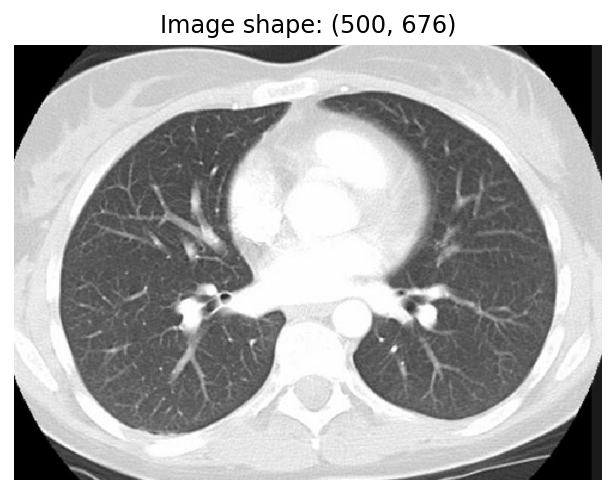

In [2]:
def normalize(image):
    return (image - np.min(image))/(np.max(image) - np.min(image))

image  = normalize(color.rgb2gray(io.imread('CT_lungs.png')))
plt.figure()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Image shape: " + str(image.shape))
plt.show()

Następnie wygenerujmy obraz koła i dodajmy do niego losowy szum i znormalizujmy do zakresu \[0, 1\].

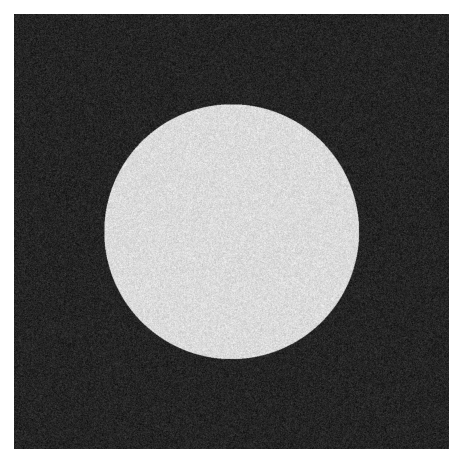

In [3]:
def generate_circle(y_size, x_size, x_origin, y_origin, radius):
    image = np.zeros((y_size, x_size))
    x_grid, y_grid = np.meshgrid(np.arange(x_size), np.arange(y_size))
    indices = np.square((x_grid - x_origin)) + np.square((y_grid-y_origin)) < radius*radius
    image[indices] = 1
    return image

y_size = 1024
x_size = 1024
circle = generate_circle(y_size, x_size, 512, 512, 300)
circle = circle + (np.random.random((y_size, x_size))-0.5)*0.4
circle = normalize(circle)

plt.figure()
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.show()


Najbardziej podstawowym algorytmem segmentacji jest progowanie polegające na uzyskaniu maski binarnej w miejscach wartości, które znajdują się w podanym zakresie.
Napisz funkcję (0.5p): 

In [5]:
def image_threshold(image, lower, upper):
    image = ((image>lower) & (image<upper))
    return image

Która jako argumenty przyjmuje obraz, dolną oraz górną wartość progu. Przykładowy wynik działania algorytmu został pokazany poniżej.

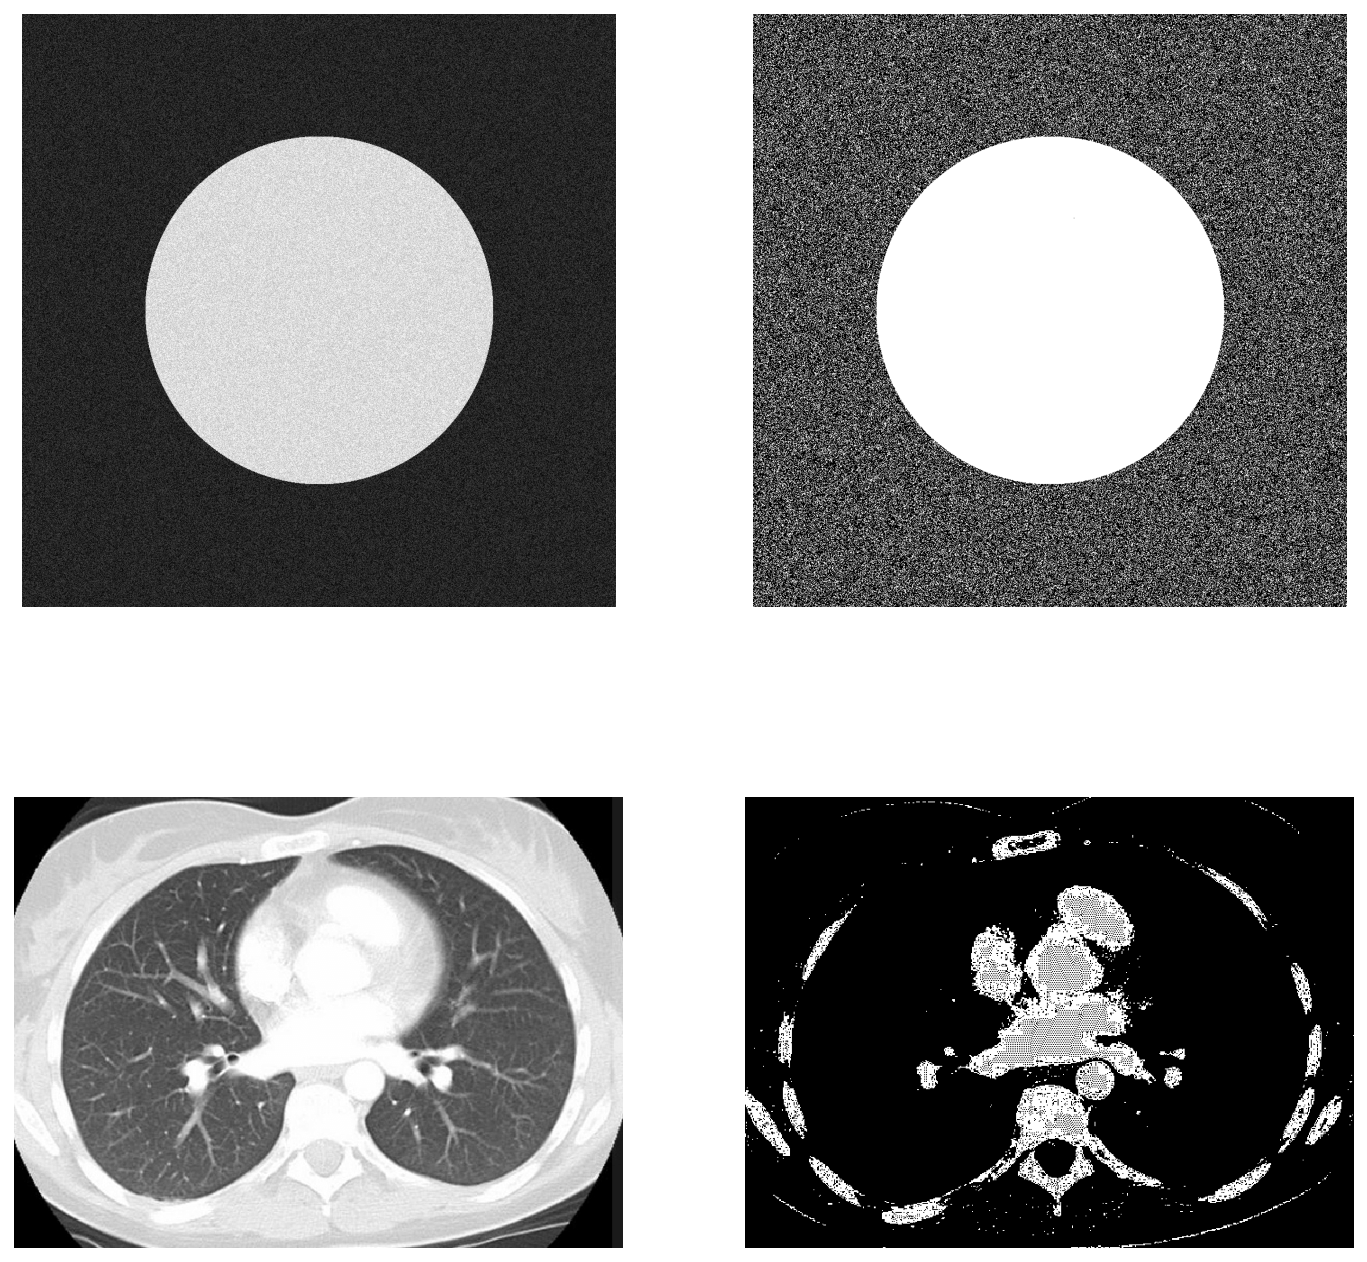

In [6]:
circle_thresholded = image_threshold(circle, 0.2, 1)
image_thresholded = image_threshold(image, 0.95, 1)

plt.figure(figsize = (12,12))
plt.subplot(2, 2, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(circle_thresholded, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(image_thresholded, cmap='gray')
plt.axis('off')
plt.show()

Kolejnym algorytmem do implementacji jest algorytm rozrostu obszarów w wersji globalnej (do implementacji, 1p,  podpowiedź: wykorzystaj funkcje label z skimage.measure)

In [7]:
def region_growing_global(image, seed, bottom_threshold, upper_threshold):
    img_thres = np.zeros(image.shape)
    w, h = np.shape(image)
    for x in range(0, w-1):
        for y in range(0, h-1):
            if image[x][y]>image[seed[0]][seed[1]]-bottom_threshold and image[x][y]<image[seed[0]][seed[1]]+upper_threshold:
                img_thres[x][y]=1
    img_label=measure.label(img_thres)
    segmentacja = np.zeros(image.shape)
    for x in range(0, w-1):
        for y in range(0, h-1):
            if img_label[x][y]==img_label[seed[0]][seed[1]]:
                segmentacja[x][y]=1
    return segmentacja

Załóżmy, że w obu przypadkach jako punkt startowy chcemy wybrać środek obrazu i że interesują nas wartości maksymalnie o 0.1 różne od punktu początkowego.

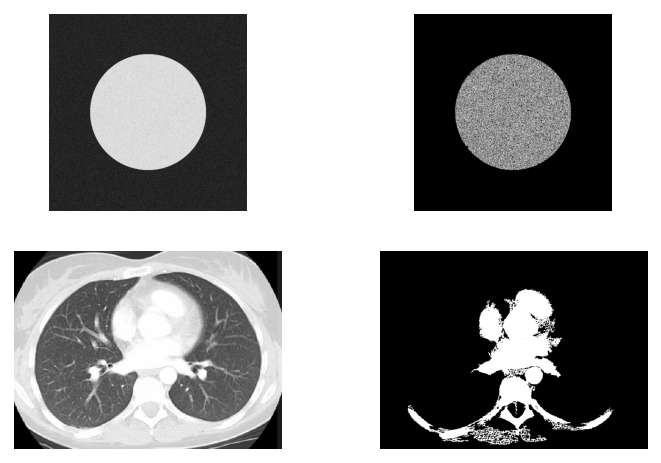

In [8]:
get_center = lambda image: (int(image.shape[0] / 2) - 1, int(image.shape[1] / 2) - 1)
circle_region_global = region_growing_global(circle, get_center(circle),  0.1, 0.1)
image_region_global = region_growing_global(image, get_center(image), 0.1, 0.1)

plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(circle_region_global, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(image_region_global, cmap='gray')
plt.axis('off')
plt.show()


Ostatnim algorytmem do implementacji jest algorytm rozrostu obszarów w wersji lokalnej (do implementacji, 1p, podpowiedź: poczytaj o algorytmie Dijkstry i odpowiednio go zmodyfikuj, przyda się biblioteka queue oraz set jako struktura danych).

In [9]:
def region_growing_local(image, seed, bottom_threshold, upper_threshold):
    low_val = image[seed] - bottom_threshold
    upp_val = image[seed] + upper_threshold

    def get_neighbours(row, col):
        yield (row-1, col)
        yield (row-1, col-1)
        yield (row-1, col+1)
        yield (row+1, col+1)
        yield  (row+1, col)
        yield (row+1, col-1)
        yield (row, col-1)
        yield (row, col+1)
    region = {seed}
    region_to_check = [seed]
    while region_to_check != []:
        to_check = region_to_check.pop(0)
        for it in get_neighbours(to_check[0], to_check[1]):
            try:
                if it not in region:
                    if low_val < image[it] and image[it] < upp_val:
                        region_to_check.append(it)
                        region.add(it)
            except IndexError:
                pass
    result = np.zeros(image.shape, dtype=bool)
    for it in region:
        result[it] = True

    return result

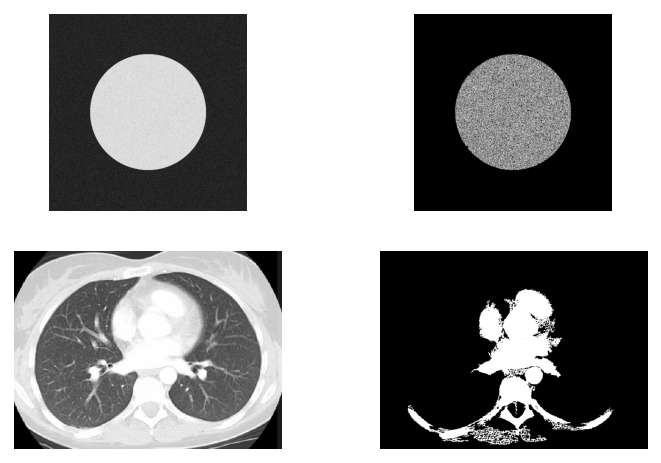

In [10]:
get_center = lambda image: (int(image.shape[0] / 2) - 1, int(image.shape[1] / 2) - 1)
circle_region_local = region_growing_local(circle, get_center(circle),  0.1, 0.1)
image_region_local = region_growing_local(image, get_center(image), 0.1, 0.1)

plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(circle_region_local, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(image_region_local, cmap='gray')
plt.axis('off')
plt.show()


Porównajmy czas wykonywania obu wersji algorytmu dla różnych wielkości okręgu.

In [12]:
y_size, x_size = 1024,1024
values = [16, 32, 64, 128, 256]
times = []
for value in values:
    current_circle = generate_circle(y_size, x_size, 512, 512, value)
    b_t = time.time()
    _ = region_growing_local(current_circle, get_center(current_circle), 0.1, 0.1)
    e_t = time.time()
    print("Time for local version, radius: ", value, ": ", e_t - b_t)
    b_t = time.time()
    _ = region_growing_global(current_circle, get_center(current_circle), 0.3, 0.3)
    e_t = time.time()
    print("Time for global version, radius: ", value, ": ", e_t - b_t)
    


Time for local version, radius:  16 :  0.0052242279052734375


Time for global version, radius:  16 :  1.9510338306427002
Time for local version, radius:  32 :  0.013020753860473633


Time for global version, radius:  32 :  1.9681682586669922
Time for local version, radius:  64 :  0.04548382759094238


Time for global version, radius:  64 :  3.0089542865753174


Time for local version, radius:  128 :  0.18718457221984863


Time for global version, radius:  128 :  2.133786201477051


Time for local version, radius:  256 :  0.8732767105102539


Time for global version, radius:  256 :  2.6376171112060547


Dlaczego algorytm w wersji lokalnej jest szybszy dla małych obiektów? Dlaczego czas obliczeń dla algorytmu w wersji globalnej nie jest zależny od wielkości obiektu? Który algorytm byłby w obecnych czasach bardziej praktyczny i dlaczego? (0.5p)

Miejce na odpowiedź:
1)Ponieważ przeszukujemy punty spełniające kryteria wokół punktu startowego i poza nim. Algorytm kończy się w momencie w którym żaden punkt nie będzie spełniał kryteriów tym samym dla małych obrazów może skończyć się bardzo szybko.
2)Czas obliczeń nie jest zależny od wielkości obiektu, ponieważ przeszukuje cały obraz i tym jest zależny od wielkości obrazu.
3)Lokalny algorytm jest bardziej praktyczny w obecnych czasach, gdyż rozdzielczość tworzonych obrazów wzrasta wraz z rozwojem technologii i coraz większy ilościowo obszar obrazu nie jest zajęty przez obiekt.

Bardziej zaawansowany algorytm segmentacji, również z XX wieku, zostanie omówiony na Laboratorium 9 - Algorytm aktywnych konturów.
Niemniej jednak, są to algorytmy historyczne stanowiące jedynie wprowadzenie do tematu.
Obecnie w kontekście segmentacji stosowane są już niemal jedynie algorytmy oparte na technikach uczenia głębokiego: https://arxiv.org/pdf/2001.05566.pdf